In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle, BoxLeastSquares
from astropy.io import fits
from scipy.optimize import curve_fit

# Cepheid Variables

In [2]:
time, mag, error = np.loadtxt('OGLE-SMC-CEP-0001.dat', unpack=True)

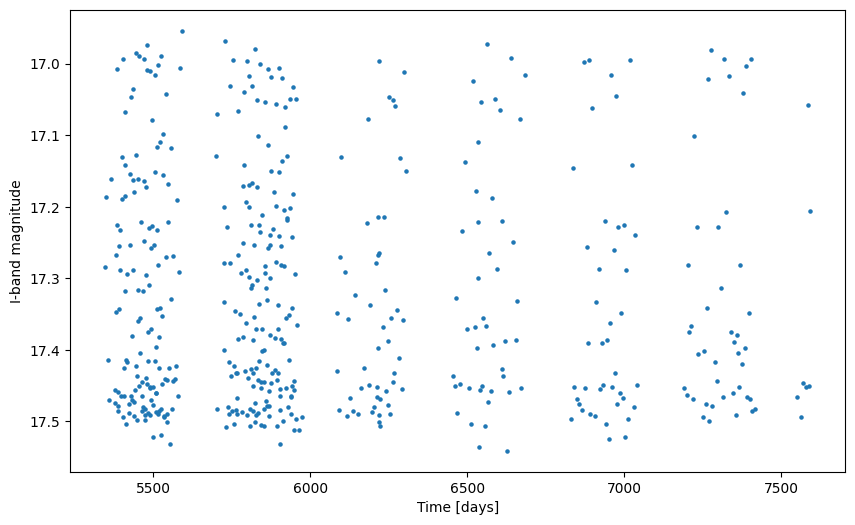

In [3]:
plt.figure(figsize=(10,6))
plt.scatter(time, mag, s=5)
plt.xlabel('Time [days]')
plt.ylabel('I-band magnitude')
plt.gca().invert_yaxis()
plt.show()

In [4]:
assumed_period = 1.1283 # Taken from the cepheid's page
phase = np.remainder(time, assumed_period)/assumed_period

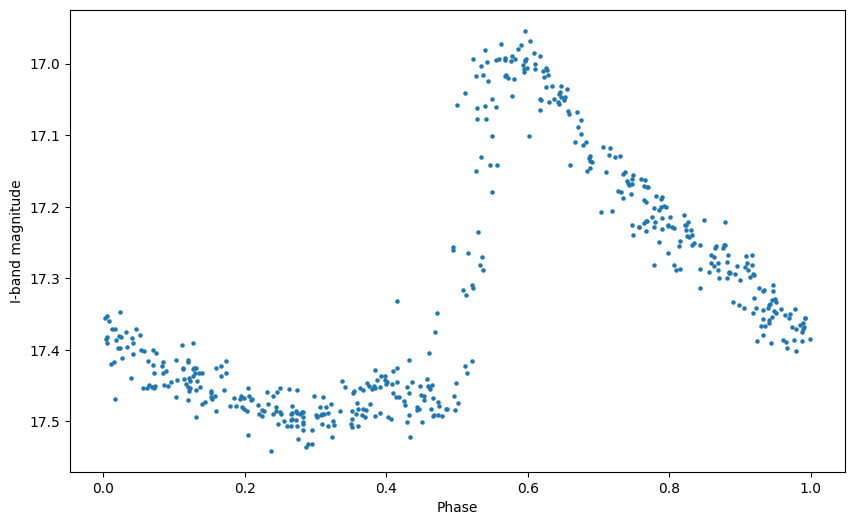

In [5]:
plt.figure(figsize=(10,6))
plt.scatter(phase, mag, s=5)
plt.xlabel('Phase')
plt.ylabel('I-band magnitude')
plt.gca().invert_yaxis()
plt.show()

In [6]:
frequency, power = LombScargle(time, mag, error).autopower(minimum_frequency=0.0001, maximum_frequency=1)

### Here, the bounds on the frequency range (minimum_frequency and maximum_frequency) are estimated by the time data and the actual period.

minimum_frequency=0.0001 --> minimum time value from time data

maximum_frequency=1 --> actual period of the cepheid

## Example workflow of Lomb-Scarge Periodogram

1. Observe a star’s light curve over months.

2. Compute the Lomb–Scargle periodogram.

3. Identify the strongest period (say, 3.5 days).

4. Phase-fold the light curve on that period → the transit or pulsation becomes clear.

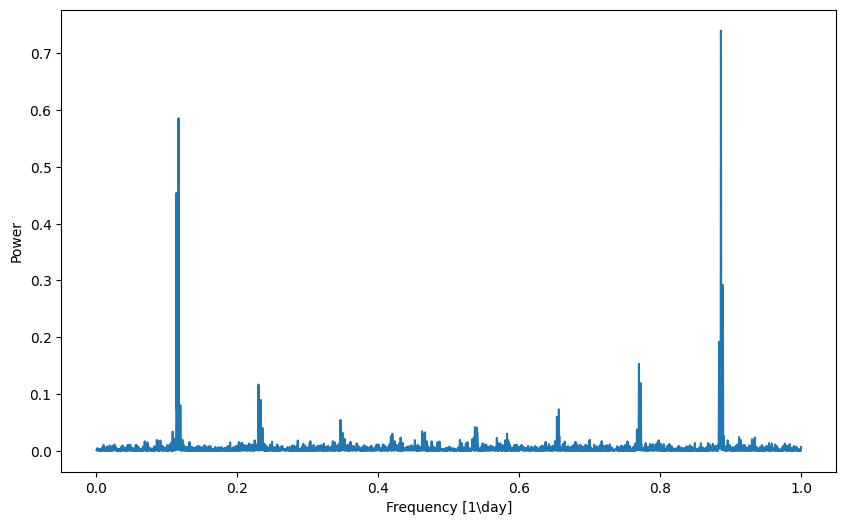

In [7]:
plt.figure(figsize=(10,6))
plt.plot(frequency, power)
plt.xlabel(r'Frequency [1\day]')
plt.ylabel('Power')
plt.show()

In [8]:
freq_idx = np.argmax(power)
req_freq = frequency[freq_idx]
actual_period = 1/req_freq
print(req_freq)
print(actual_period)

0.8862948296703771
1.128292715384463


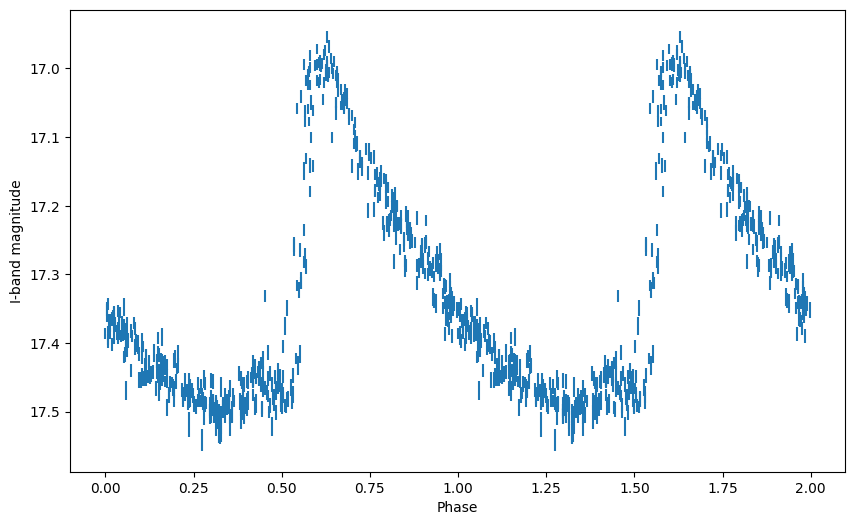

In [9]:
actual_phase = np.remainder(time, actual_period)/actual_period

plt.figure(figsize=(10,6))
plt.errorbar(np.append(actual_phase, actual_phase+1), np.append(mag, mag), np.append(error, error), ls='')
plt.ylabel('I-band magnitude')
plt.xlabel('Phase')
plt.gca().invert_yaxis()
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------

### When you fold light curve data to the star’s period, your phase runs from 0 to 1. But if you plot just that, the variation may look “cut off” at the boundaries. Duplicating it in [1, 2] makes the periodic pattern much easier to see. Hence, np.append() is used in plt.errorbar().

---------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
print(f"The period estimate using Lomb-Scargle Peridograph is: {actual_period:.4f} days.")

The period estimate using Lomb-Scargle Peridograph is: 1.1283 days.


---------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
I_mag, period = np.loadtxt('query_1755850396.79012r.txt', usecols=(4, 5), unpack=True, dtype='str')
# dtype='str' is used to filter out the missing I band magnitude values designated as '-99.99'.

In [12]:
I_mag_idx = np.where(I_mag != "-99.99")
I_mag_sub = I_mag[I_mag_idx].astype('f') # Converting the strings back to float numbers
period_sub = period[I_mag_idx].astype('f')

In [13]:
print(I_mag_sub.shape)
print(period_sub.shape)

(2750,)
(2750,)


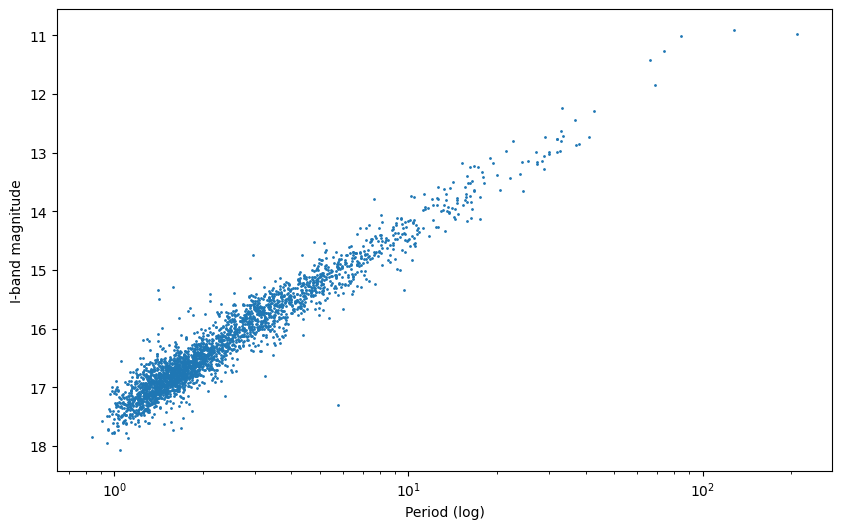

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(period_sub, I_mag_sub, s=1)
plt.xscale("log")
plt.xlabel('Period (log)')
plt.ylabel('I-band magnitude')
plt.gca().invert_yaxis()
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------

# Exoplanets

In [15]:
exoplanet_data = fits.getdata("kplr010666592-2009131110544_slc.fits")

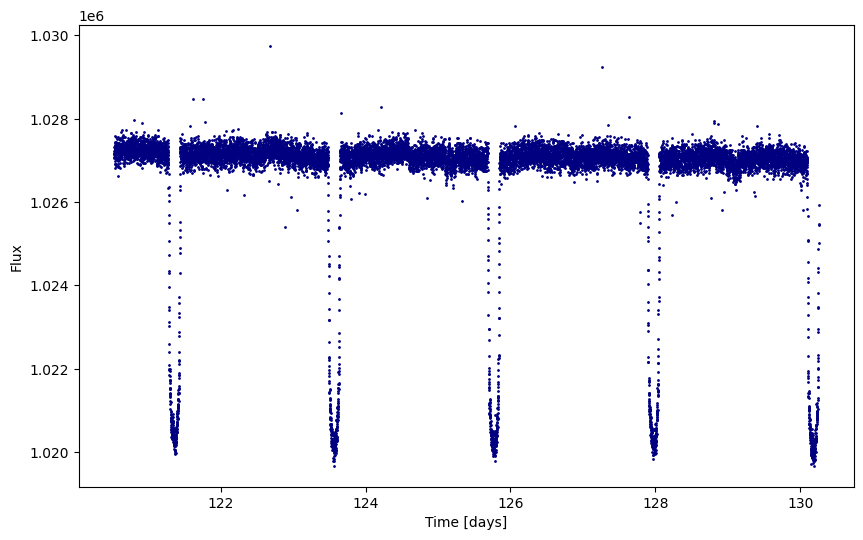

In [16]:
Time = exoplanet_data['time']
SAP_flux = exoplanet_data['sap_flux']

plt.figure(figsize=(10,6))
plt.scatter(Time, SAP_flux, s=1, color='navy')
plt.xlabel('Time [days]')
plt.ylabel('Flux')
plt.show()

In [17]:
nan_vals = np.isnan(SAP_flux) # There are NaN values present in the flux data. np.isnan gives indices of these NaN values.
model = BoxLeastSquares(Time[~nan_vals], SAP_flux[~nan_vals], dy=None) # ~ excludes the nan_value indices from the the time and flux data.

In [18]:
periodogram  = model.autopower(duration=0.2)
# model.autopower automatically generates a grid of trial periods (uniform in frequency) and computes the periodogram
period = periodogram.period
power = periodogram.power

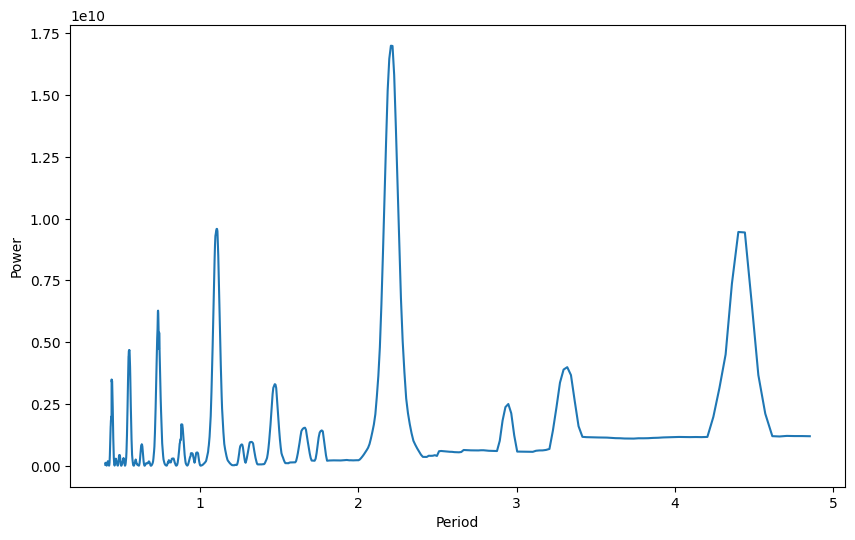

In [19]:
plt.figure(figsize=(10,6))
plt.plot(period, power)
plt.xlabel('Period')
plt.ylabel('Power')
plt.show()

In [20]:
period_idx = np.argmax(power)
actual_period = period[period_idx]
print(actual_period)
print(period_idx)

2.2055172439293367
968


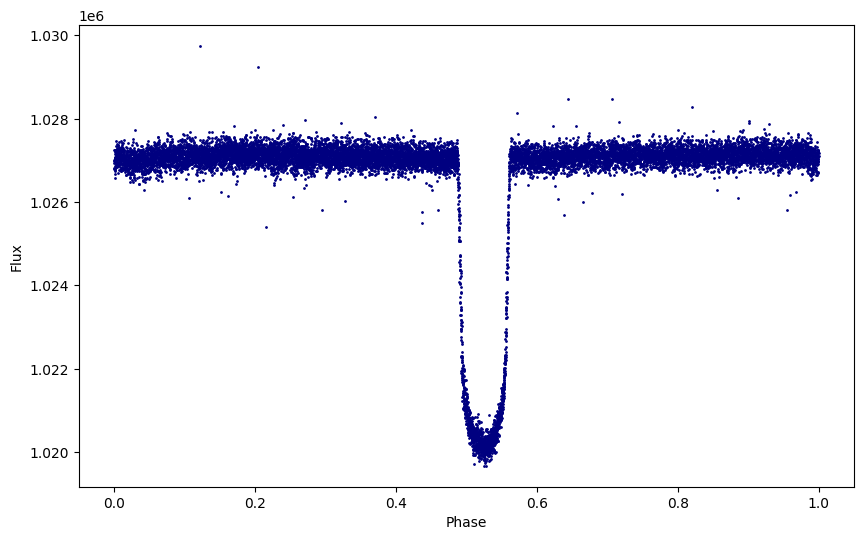

In [21]:
phase = np.remainder(Time+actual_period/2, actual_period)/actual_period

plt.figure(figsize=(10,6))
plt.scatter(phase, SAP_flux, s=1, color='navy')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------

# Gamma Ray Bursts

In [22]:
hdu = fits.open('AS1A02_005T01_9000000948_06884cztM0_level2_common_clean.evt')

In [23]:
times = np.concatenate((hdu[1].data['Time'], hdu[2].data['Time'],
                        hdu[3].data['Time'], hdu[4].data['Time']))

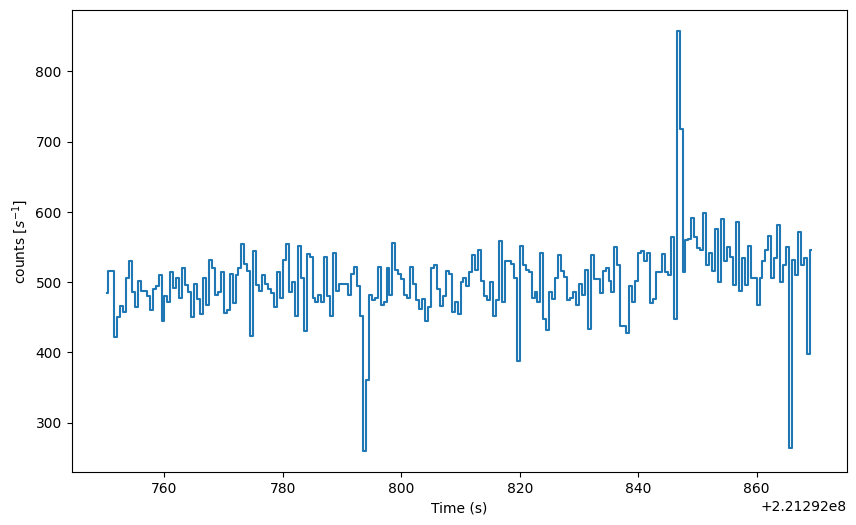

In [24]:
binsize = 0.5 # A bin size of 0.5 brings out the transient event more clearly.

#The detectors are switched off above certain regions of the Earth, known as the South-Atlantic Anomaly
# tbins = np.arange(times.min(), times.max(), binsize)

tbins = np.arange(221292750.0, 221292870.0, binsize) # data containing the GRB

counts, bins = np.histogram(times, bins=tbins)
bins = (bins[1:] + bins[:-1])/2

plt.figure(figsize=(10,6))
plt.step(bins, counts/binsize, where='mid')
plt.xlabel('Time (s)')
plt.ylabel(r'$\text{counts} \ [s^{-1}]$')
plt.show()

# Final task

The GCN has data in the 'g' filter. The columns are Julian Days (essentially, time of observation), dt_minutes (time after the GRB was detected in X-rays, in minutes), and magnitude and error in magnitude.

| JD          | dt_minutes | ap_mag | Mag_err |
|-------------|------------|--------|---------|
| 2458725.366 | 51.16      | 16.93  | 0.01    |
| 2458725.372 | 59.80      | 17.21  | 0.02    |
| 2458725.394 | 91.48      | 18.00  | 0.12    |
| 2458725.400 | 100.12     | 18.08  | 0.04    |


Your final task for today is to plot the light curve from this GRB afterglow and verify the power law given in the GCN.

In [25]:
jd, time, mag, mag_error = np.loadtxt('transient.txt', unpack=True, skiprows=1)

In [26]:
def linear_model(m, x, c):
    return m * x + c

### Expression relating magnitude and flux is:

$$
m = -2.5 \log_{10}\!\left(\frac{F}{F_0}\right)
$$

- (-mag/2.5) converts magnitude into log(Flux).

In [27]:
popt, pcov = curve_fit(linear_model, np.log10(time), -mag/2.5)
m, c = popt

In [28]:
print(m)
print(c)

-1.619952748593237
-4.005859095657395


In [29]:
model = linear_model(m, np.log10(time), c)

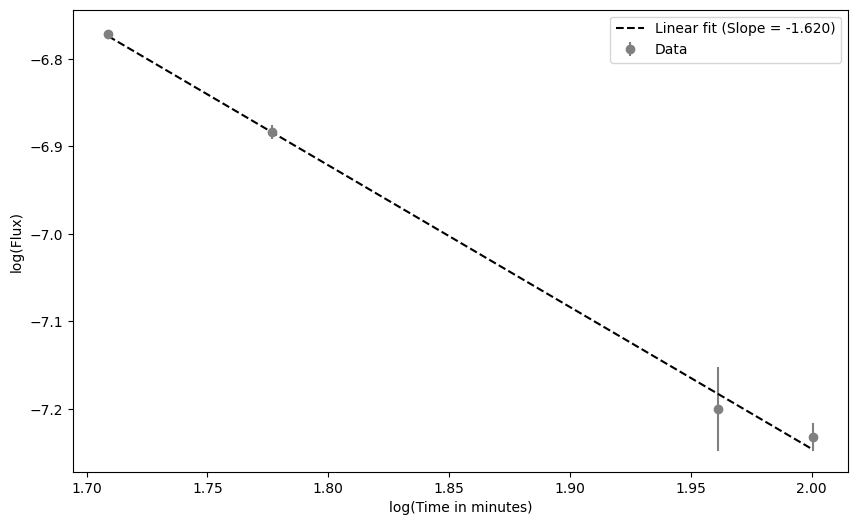

In [30]:
plt.figure(figsize=(10,6))
plt.errorbar(np.log10(time),-mag/2.5, yerr=np.abs(-mag_error/2.5), label='Data', fmt='o', color='gray')
plt.plot(np.log10(time), model, label=f'Linear fit (Slope = {m:.3f})', linestyle='--', color='k')
plt.xlabel('log(Time in minutes)')
plt.ylabel('log(Flux)')
plt.legend()
plt.show()